In [20]:
import numpy as np 

import pandas as pd 
import matplotlib.pyplot as plt 
import shutil 
from os import listdir, makedirs, getcwd, remove 
from os.path import isfile, join, abspath, exists, isdir, expanduser 
import matplotlib.image as mimg
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
from handcrafted_descriptors.grid_classification import utils
import tensorflow as tf 
from keras import layers 
from keras import models 
from keras import optimizers 
from sklearn.preprocessing import LabelEncoder 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 


import import_ipynb
import define_svm


In [2]:
def plot_and_save_image(running_corrects,val_running_corrects, running_loss,val_running_loss, title, direc):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    fig.suptitle(title)
    ax1.plot(running_corrects)
    ax1.plot(val_running_corrects)
    ax1.set_title('model accuracy')

    ax1.legend(['train', 'test'], loc='upper left')
    ax2.plot(running_loss)
    ax2.plot(val_running_loss)
    ax2.set_title('model loss')

    ax2.legend(['train', 'test'], loc='upper left')
    
    c = ['accuracy','loss']
    j = 0
    for ax in [ax1,ax2]:
        
        ax.set(xlabel='epochs', ylabel=c[j])
        j = j+1
    ax1.grid()
    ax2.grid()
    plt.savefig(direc)

# COLLECTING DATA 

In [3]:
species_pth = '../../../data/train'
species = listdir(species_pth)

In [4]:
# create dataframe with species and it's path for the image patch!
lichens =[]

for sp in species:
    dr = join(join(species_pth, sp))
    al_img = listdir(dr)
    
    for imgs in al_img:
        img_dir =join(dr,imgs)
        lichens.append((sp, img_dir))

        
# create dataframe


lichens_dataframe =pd.DataFrame(data = lichens, columns = ['category', 'image'],index = None)

In [5]:
print("Total number of lichens patch in the dataset: ", len(lichens))
fl_count = lichens_dataframe['category'].value_counts()
print("lichens patch in each category: ")
print(fl_count)

Total number of lichens patch in the dataset:  1200
lichens patch in each category: 
Lecanora_chlarotera           72
Caloplaca_cerina              72
Melanelixia_glabratula        60
Phaeophyscia_orbicularis      60
Physcia_biziana               60
Candelariella_reflexa         60
Arthonia_radiata              60
Ramalina_farinacea            60
Ramalina_fastigiata           60
flavoparmenia_soredians       60
Physconia_grisea              60
Lecanora_argentata            60
Xanthomendoza_fulva           60
Candelariella_xanthostigma    60
Chrysothrix_candelaris        60
Flavoparmelia_caperata        60
Xanthomendoza_fallax          60
Hyperphyscia_adglutinata      60
Lecidella_elaeochroma         48
Gyalolechia_flavorubescens    48
Name: category, dtype: int64


80


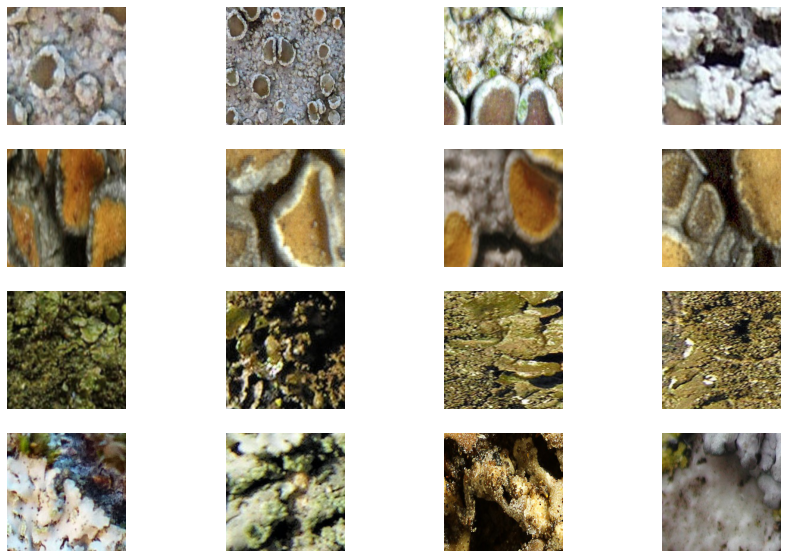

In [6]:
# Let's visualize some lichen's crops from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = lichens_dataframe['image'][lichens_dataframe['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)
print(len(random_samples))
        
# Plot the samples
f, ax = plt.subplots(4,4, figsize=(15,10))
for i,sample in enumerate(random_samples[:16]):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

In [7]:
%mkdir -p data/train
%mkdir -p data/valid
current_dir_train = join(getcwd(),'data/train')
current_dir_val = join(getcwd(),'data/valid')

for sp in species:
    join(current_dir_train),sp
    makedirs(join(current_dir_train,sp))
current_dir_val = join(getcwd(),'data/valid')

for sp in species:
    join(current_dir_val),sp
    makedirs(join(current_dir_val,sp))

    for sp in species:
    join(current_dir_val),sp
    makedirs(join(current_dir_val,sp))


# move 75% of the images in training direcory and the remaining in the validation directory
for category in fl_count.index:
    samples =lichens_dataframe['image'][lichens_dataframe['category'] == category].values
    tr_num = len(samples)*75//100
    perm = np.random.permutation(samples)
    for i in range(tr_num):
        print(i)
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'data/train/'+ str(category) + '/' + name)
    print('*****************************************************')
    for i in range(tr_num,len(samples)):
        print(i)
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'data/valid/'+ str(category) + '/' + name)       
    

IndentationError: expected an indented block (<ipython-input-7-04dae5deb9a7>, line 16)

# USING PRE-TRAINED CONVNET

In [7]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (100, 100, 3))

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

# FEATURE EXTRACTION 

We can extract features of our images dataset using a pretrained model. This is called Feature Extraction. There are 2 ways to use this method, first one doesn't support data augmentation, but however the second method is usable with data augmentation.

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16

## NO DATA AUGMENTATION

In [14]:
# write a function which extracts features, and then train an SVM or another neural network

current_dir_train = '../../../data/train'
current_dir_val = '../../../data/valid'
def feature_extraction(directory, sample_count):
    
    # pre_allocated memory
    #features = []
    #labels_dummy = []
    features = np.zeros(shape = (sample_count,3,3,512))
    labels_dummy = np.zeros(shape = (sample_count,20))
    labels =np.zeros(shape = (sample_count,1))
    
    generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory, target_size = (100, 100), 
                                                                            batch_size = batch_size, class_mode = 'categorical')
    
    
    
    i = 0
    
    
    print('enter in loop')
    
    for input_batch, labels_batch in generator:
        
        features_batch = conv_base.predict(input_batch)
        features[i*batch_size : (i + 1)*batch_size] = features_batch 
        labels_dummy[i*batch_size : (i + 1)*batch_size] = labels_batch
        #features.append(features_batch)
        #labels_dummy.append(labels_batch)
        
        i = i + 1
        
        if i*batch_size >= sample_count:
            break
    
    
    #features = np.array(features)
    #labels_dummy = np.array(labels_dummy)
    return features, labels_dummy
    
    
    
#train_features, train_labels_dummy = feature_extraction(current_dir_train, 1200)   
    
validation_features, validation_labels_dummy = feature_extraction(current_dir_val, 400)   



    
    

Found 400 images belonging to 20 classes.
enter in loop


In [15]:
# create labels vector 
def from_dummy_to_labels(dummy_vec):
    res = np.zeros(dummy_vec.shape[0])
    for i in range(dummy_vec.shape[0]):
        tmp = list(dummy_vec[i])
        res[i] = tmp.index(1)
    return res

In [16]:
training_labels = from_dummy_to_labels(train_labels_dummy)
validation_labels = from_dummy_to_labels(validation_labels_dummy)

train_features = np.reshape(train_features, (1200, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (400, 3 * 3 * 512))

## TRAIN A SVM MODEL  WITH EXTRACTED FEATURES!

In [26]:
svc, _ , _ = define_svm.define_and_train_svm(train_features, training_labels, 'linear')
svc.score(validation_features,validation_labels)

here


0.6525612472160356

In [17]:
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import pickle
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
def search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'C': [ 100, ], 'gamma': [  0.1]}
    clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0,skmetrics.accuracy_score(y_pred, tst_lab)

def search_for_best_poly(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'degree':[2,3,4,5,6,7],'C': [1e-3,1e-2, 1e-1, 1e0, 1e1, 1e2,1e3], 'gamma': [  0.00001,0.0001,0.001, 0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='degree'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0, skmetrics.accuracy_score(y_pred, tst_lab)

def create_and_save_confusion_matrix(model, tst_features, tst_lab, species,director, name ):
    pred = model.predict(tst_features)
    df = utils.evaluated_prediction(pred, tst_lab, species)
    cm = utils.build_confusion_matrix(df, pred, tst_lab,species)
    fig=plt.figure(figsize=(30, 15))
    utils.plot_confusion_matrix(cm,species,name,director,normalize=True,title='Confusion matrix')
    plt.close()
    return pred

def calculate_and_plot_precision_recall(tst_lab, pred, species, directory, string):
    precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, pred)
    
    df = pd.DataFrame({"X":species, "precision":precision,"recall":recall,'f1score': fbeta})
    df.plot(x="X", y=["precision", "recall",'f1score'], kind="bar")
    plt.tight_layout()
    plt.savefig(directory +'precision_recall_class4class'+string+'.jpg')
    return np.mean(precision), np.mean(recall), np.mean(fbeta)


In [18]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
svc  = OneVsRestClassifier(SVC(kernel = 'poly',gamma = 'scale', degree = 3),n_jobs = -1)
svc = svc.fit(train_features, training_labels)

In [29]:
svc.score(validation_features,validation_labels)

0.66

precision:  0.6481138204858389
recall:  0.6395833333333333


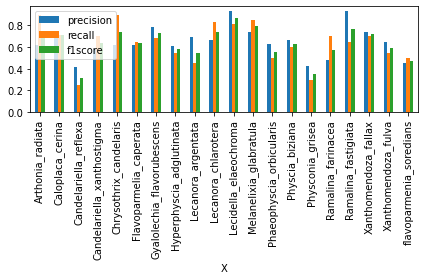

In [30]:
a,b,c = calculate_and_plot_precision_recall(validation_labels, prd, species, '', 'pra_poly9')
print('precision: ',a)
print('recall: ',b)

In [22]:
prd = create_and_save_confusion_matrix(svc, validation_features,validation_labels, species,'', '_vgg16_poly8' )

precision:  0.6481138204858389
recall:  0.6395833333333333


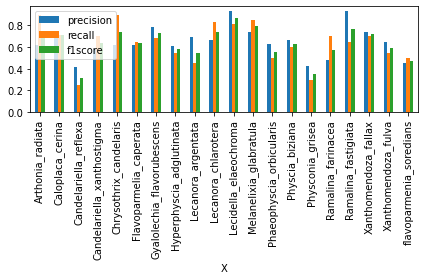

In [23]:
a,b,c = calculate_and_plot_precision_recall(validation_labels, prd, species, '', 'pra_poly9')
print('precision: ',a)
print('recall: ',b)

In [ ]:
# doing some test on svm 
def test_accuracy(test_features,features,gram, test_label,svc):
    num_objects = features.shape[0]
    res = []
    prediction = []
    for i,ft in enumerate(test_features):
        pred = svc.predict(np.array([np.dot(gram, ft)]))
        prediction.append(pred[0])
        #print(i,": ",pred," : ",test_label[i])
        if(pred==test_label[i]):
            res.append(1)
        else:
            res.append(0)

    res = np.array(res).reshape(-1)
    return np.sum(res)/res.shape, np.array(prediction)


In [ ]:
res, pred = test_accuracy(validation_features ,train_features,c, validation_labels, svc)

print(res)

